In [210]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


#warning
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)

In [211]:
df = pd.read_csv("cardata_for_model.csv")

In [212]:
df.head()

,Fiyat,Marka,Yıl,Kilometre,Vites Tipi,Yakıt Tipi,Kasa Tipi,Renk,Motor Hacmi,Motor Gücü,Çekiş,Ort. Yakıt Tüketimi,Yakıt Deposu,Agirlik,Silindir_Sayisi,Maksimum Hız
0,1475000.00,Honda,2023,6100.00,Otomatik,Benzin,Sedan,Mavi,1498,129,Önden Çekiş,6.50,47,2050,4.00,248
1,610000.00,Volkswagen,2008,210000.00,Düz,Benzin,Sedan,Lacivert,1598,115,Önden Çekiş,7.50,70,1548,4.00,180
2,715000.00,Fiat,2020,69000.00,Düz,Benzin,Sedan,Beyaz,1368,95,Önden Çekiş,5.70,45,1548,4.00,180
3,620000.00,Hyundai,2012,199000.00,Otomatik,Dizel,Sedan,Füme,1582,128,Önden Çekiş,5.60,43,1798,4.00,200
4,618000.00,Citroen,2021,101000.00,Düz,Dizel,Sedan,Beyaz,1499,100,Önden Çekiş,3.90,50,1675,4.00,185


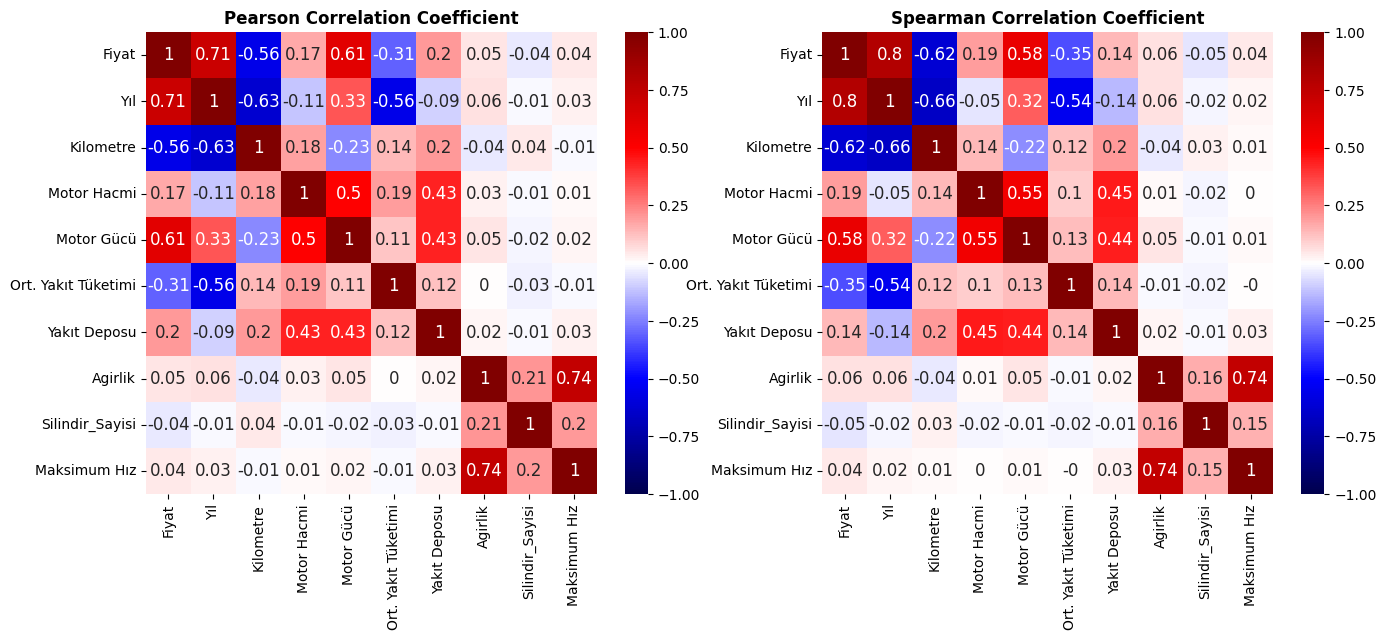

In [213]:
plt.figure(figsize=[16,6])

plt.subplot(1,2,1)
plt.title('Pearson Correlation Coefficient', weight='bold')
sns.heatmap(df.corr(method='pearson').round(2), cmap="seismic", annot=True, vmin=-1, vmax=1, annot_kws={"size": 12});

plt.subplot(1,2,2)
plt.title('Spearman Correlation Coefficient', weight='bold')
sns.heatmap(df.corr(method='spearman').round(2), cmap="seismic", annot=True, vmin=-1, vmax=1, annot_kws={"size": 12});

plt.show()

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fiyat                1604 non-null   float64
 1   Marka                1604 non-null   object 
 2   Yıl                  1604 non-null   int64  
 3   Kilometre            1604 non-null   float64
 4   Vites Tipi           1604 non-null   object 
 5   Yakıt Tipi           1604 non-null   object 
 6   Kasa Tipi            1604 non-null   object 
 7   Renk                 1604 non-null   object 
 8   Motor Hacmi          1604 non-null   int64  
 9   Motor Gücü           1604 non-null   int64  
 10  Çekiş                1604 non-null   object 
 11  Ort. Yakıt Tüketimi  1604 non-null   float64
 12  Yakıt Deposu         1604 non-null   int64  
 13  Agirlik              1604 non-null   int64  
 14  Silindir_Sayisi      1604 non-null   float64
 15  Maksimum Hız         1604 non-null   i

In [215]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


categorical_columns = ['Marka', 'Vites Tipi', 'Yakıt Tipi', 'Kasa Tipi', 'Renk', 'Çekiş']


corr_matrix_df = pd.DataFrame(index=categorical_columns, columns=categorical_columns)


for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            
            corr_value = cramers_v(df[col1], df[col2])
            corr_matrix_df.loc[col1, col2] = corr_value


print("Kramers V Korelasyon Matrisi:")
print(corr_matrix_df)

Kramers V Korelasyon Matrisi:
           Marka Vites Tipi Yakıt Tipi Kasa Tipi Renk Çekiş
Marka        NaN       0.44       0.37      0.21 0.16  0.82
Vites Tipi  0.44        NaN       0.24      0.02 0.13  0.13
Yakıt Tipi  0.37       0.24        NaN      0.09 0.14  0.07
Kasa Tipi   0.21       0.02       0.09       NaN 0.38  0.03
Renk        0.16       0.13       0.14      0.38  NaN  0.50
Çekiş       0.82       0.13       0.07      0.03 0.50   NaN


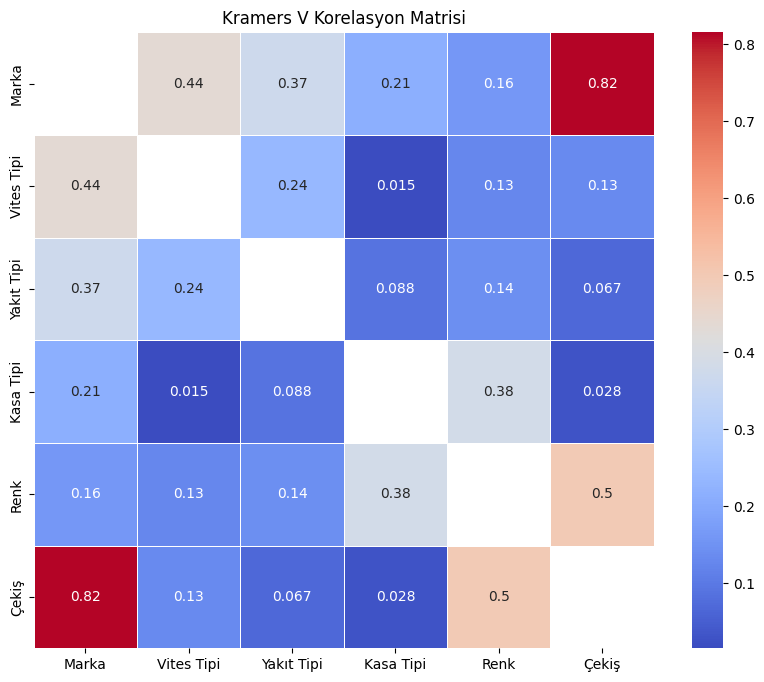

In [216]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_df.astype(float), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Kramers V Korelasyon Matrisi')
plt.show()

In [217]:
df

,Fiyat,Marka,Yıl,Kilometre,Vites Tipi,Yakıt Tipi,Kasa Tipi,Renk,Motor Hacmi,Motor Gücü,Çekiş,Ort. Yakıt Tüketimi,Yakıt Deposu,Agirlik,Silindir_Sayisi,Maksimum Hız
0,1475000.00,Honda,2023,6100.00,Otomatik,Benzin,Sedan,Mavi,1498,129,Önden Çekiş,6.50,47,2050,4.00,248
1,610000.00,Volkswagen,2008,210000.00,Düz,Benzin,Sedan,Lacivert,1598,115,Önden Çekiş,7.50,70,1548,4.00,180
2,715000.00,Fiat,2020,69000.00,Düz,Benzin,Sedan,Beyaz,1368,95,Önden Çekiş,5.70,45,1548,4.00,180
3,620000.00,Hyundai,2012,199000.00,Otomatik,Dizel,Sedan,Füme,1582,128,Önden Çekiş,5.60,43,1798,4.00,200
4,618000.00,Citroen,2021,101000.00,Düz,Dizel,Sedan,Beyaz,1499,100,Önden Çekiş,3.90,50,1675,4.00,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,470999.00,Renault,2013,256000.00,Düz,Benzin,Hatchback/5,Bordo,1149,75,Önden Çekiş,5.50,45,1450,4.00,170
1600,642000.00,BMW,2011,132000.00,Otomatik,LPG & Benzin,Hatchback/5,Beyaz,1596,116,Arkadan İtiş,7.50,53,1675,4.00,185
1601,430000.00,Peugeot,2007,285000.00,Düz,Dizel,Sedan,Siyah,1560,112,Önden Çekiş,5.30,66,1790,4.00,205
1602,788000.00,Volkswagen,2014,135000.00,Yarı Otomatik,Dizel,Sedan,Füme,1598,105,Önden Çekiş,4.70,55,1990,4.00,215


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fiyat                1604 non-null   float64
 1   Marka                1604 non-null   object 
 2   Yıl                  1604 non-null   int64  
 3   Kilometre            1604 non-null   float64
 4   Vites Tipi           1604 non-null   object 
 5   Yakıt Tipi           1604 non-null   object 
 6   Kasa Tipi            1604 non-null   object 
 7   Renk                 1604 non-null   object 
 8   Motor Hacmi          1604 non-null   int64  
 9   Motor Gücü           1604 non-null   int64  
 10  Çekiş                1604 non-null   object 
 11  Ort. Yakıt Tüketimi  1604 non-null   float64
 12  Yakıt Deposu         1604 non-null   int64  
 13  Agirlik              1604 non-null   int64  
 14  Silindir_Sayisi      1604 non-null   float64
 15  Maksimum Hız         1604 non-null   i

In [219]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])


In [220]:
numeric_df.head()

,Fiyat,Yıl,Kilometre,Motor Hacmi,Motor Gücü,Ort. Yakıt Tüketimi,Yakıt Deposu,Agirlik,Silindir_Sayisi,Maksimum Hız
0,1475000.00,2023,6100.00,1498,129,6.50,47,2050,4.00,248
1,610000.00,2008,210000.00,1598,115,7.50,70,1548,4.00,180
2,715000.00,2020,69000.00,1368,95,5.70,45,1548,4.00,180
3,620000.00,2012,199000.00,1582,128,5.60,43,1798,4.00,200
4,618000.00,2021,101000.00,1499,100,3.90,50,1675,4.00,185


In [221]:
numeric_df.columns = numeric_df.columns.str.replace('.', '_')
numeric_df.columns = numeric_df.columns.str.replace(' ', '_')
numeric_df.columns = numeric_df.columns.str.replace('.', '_')


In [222]:
# Model 1
ols_lm = smf.ols('Fiyat ~ Yıl + Kilometre + Motor_Hacmi + Motor_Gücü + Ort__Yakıt_Tüketimi + Yakıt_Deposu + Agirlik + Maksimum_Hız', data=numeric_df)
model_1 = ols_lm.fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Fiyat   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     469.1
Date:                Thu, 23 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:47:04   Log-Likelihood:                -21305.
No. Observations:                1604   AIC:                         4.263e+04
Df Residuals:                    1595   BIC:                         4.268e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3.328e+07   2.31e+06    -14.408      0.000   -3.78e+07   -2.88e+07
Yıl                  1.656e+04   1139.947     14.529      0.000    1.43e+04    1.88e+04
Kilometre              -0.8142      0.062    -13.122      0.000      -0.936      -0.693
Motor_Hacmi            78.2937     32.721      2.393      0.017      14.113     142.474
Motor_Gücü           4986.5011    267.845     18.617      0.000    4461.136    5511.867
Ort__Yakıt_Tüketimi -2.784e+04   3986.322     -6.983      0.000   -3.57e+04      -2e+04
Yakıt_Deposu         4585.4271    631.280      7.264      0.000    3347.201    5823.653
Agirlik               -29.4509     26.304     -1.120      0.263     -81.045      22.144
Maksimum_Hız          394.5747    302.253      1.305      0.192    -198.281     987.430
==============================================================================
Omnibus:                      649.974   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5463.571
Skew:                           1.670   Prob(JB):                         0.00
Kurtosis:                      11.402   Cond. No.                     1.22e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [223]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Bağımsız değişkenlere sabit terim ekleyerek X matrisini oluştur
X = sm.add_constant(numeric_df[['Yıl', 'Kilometre', 'Motor_Hacmi', 'Motor_Gücü', 'Ort__Yakıt_Tüketimi', 'Yakıt_Deposu', 'Agirlik', 'Maksimum_Hız']])

# Bağımsız değişkenlerin VIF değerlerini hesapla
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sonuçları görüntüle
print(vif_data)

              Variable       VIF
0                const 422305.91
1                  Yıl      3.42
2            Kilometre      2.01
3          Motor_Hacmi      1.59
4           Motor_Gücü      2.17
5  Ort__Yakıt_Tüketimi      1.96
6         Yakıt_Deposu      1.44
7              Agirlik      2.20
8         Maksimum_Hız      2.19


In [224]:
## Sayısal değişkenlerimin VIF değerleri 5 ten küçük olduğu için benim modelimde multicollinearity sorunu yok.

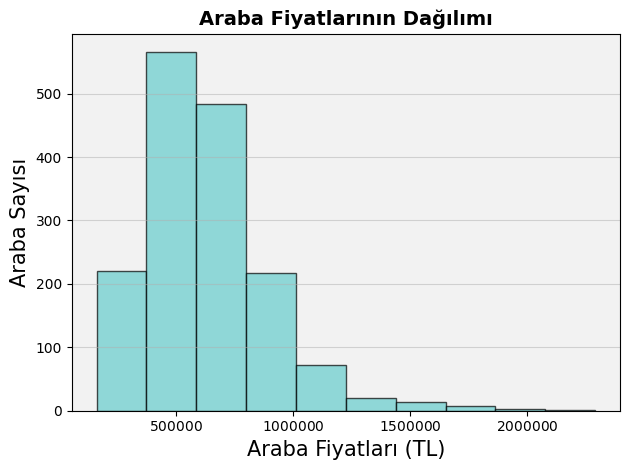

In [225]:
from matplotlib.ticker import ScalarFormatter
plt.hist(df['Fiyat'], bins=10, edgecolor='black', color='#66CCCC', alpha=0.7)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='x')

plt.xlabel('Araba Fiyatları (TL)', fontsize=15)
plt.ylabel('Araba Sayısı', fontsize=15)
plt.title('Araba Fiyatlarının Dağılımı', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F2F2F2')
plt.tight_layout()
plt.show()

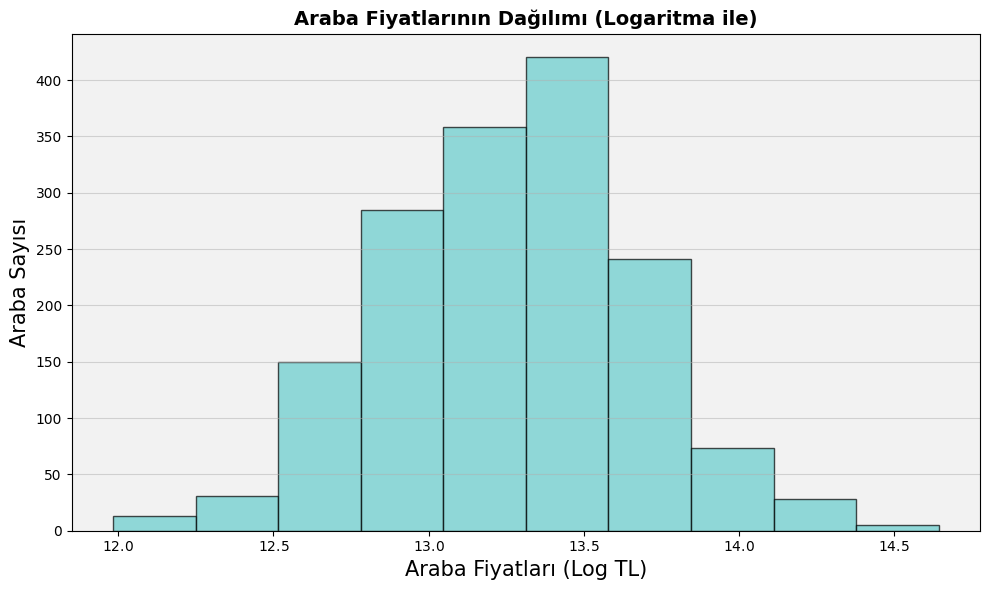

In [226]:
plt.figure(figsize=[10, 6])
plt.hist(np.log1p(df['Fiyat']), bins=10, edgecolor='black', color='#66CCCC', alpha=0.7)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='x')

plt.xlabel('Araba Fiyatları (Log TL)', fontsize=15)
plt.ylabel('Araba Sayısı', fontsize=15)
plt.title('Araba Fiyatlarının Dağılımı (Logaritma ile)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F2F2F2')
plt.tight_layout()
plt.show()

In [227]:
numeric_df['Log_Fiyat'] = np.log(numeric_df['Fiyat'])

# Model 2
ols_lm_log = smf.ols('Log_Fiyat ~ Yıl + Kilometre + Motor_Hacmi + Motor_Gücü + Ort__Yakıt_Tüketimi + Yakıt_Deposu + Agirlik + Maksimum_Hız', data=numeric_df)
model_2 = ols_lm_log.fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Log_Fiyat   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     720.8
Date:                Thu, 23 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:47:06   Log-Likelihood:                 421.34
No. Observations:                1604   AIC:                            -824.7
Df Residuals:                    1595   BIC:                            -776.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -57.1572      3.028    -18.878      0.000     -63.096     -51.218
Yıl                     0.0346      0.001     23.126      0.000       0.032       0.037
Kilometre           -1.085e-06   8.13e-08    -13.337      0.000   -1.24e-06   -9.25e-07
Motor_Hacmi             0.0001   4.29e-05      3.324      0.001    5.84e-05       0.000
Motor_Gücü              0.0066      0.000     18.670      0.000       0.006       0.007
Ort__Yakıt_Tüketimi    -0.0363      0.005     -6.943      0.000      -0.047      -0.026
Yakıt_Deposu            0.0071      0.001      8.588      0.000       0.005       0.009
Agirlik             -2.027e-05   3.45e-05     -0.588      0.557   -8.79e-05    4.74e-05
Maksimum_Hız            0.0005      0.000      1.257      0.209      -0.000       0.001
==============================================================================
Omnibus:                       43.721   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.696
Skew:                          -0.125   Prob(JB):                     7.44e-21
Kurtosis:                       4.151   Cond. No.                     1.22e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [271]:
numeric_df.head()

,Fiyat,Yıl,Kilometre,Motor_Hacmi,Motor_Gücü,Ort__Yakıt_Tüketimi,Yakıt_Deposu,Agirlik,Silindir_Sayisi,Maksimum_Hız,Log_Fiyat
0,1475000.00,2023,6100.00,1498,129,6.50,47,2050,4.00,248,14.20
1,610000.00,2008,210000.00,1598,115,7.50,70,1548,4.00,180,13.32
2,715000.00,2020,69000.00,1368,95,5.70,45,1548,4.00,180,13.48
3,620000.00,2012,199000.00,1582,128,5.60,43,1798,4.00,200,13.34
4,618000.00,2021,101000.00,1499,100,3.90,50,1675,4.00,185,13.33


In [228]:
data_1 = df.select_dtypes(include=['int64', 'float64'])
data_1["Vites Tipi"] = df["Vites Tipi"]


In [229]:
data_1.head()

,Fiyat,Yıl,Kilometre,Motor Hacmi,Motor Gücü,Ort. Yakıt Tüketimi,Yakıt Deposu,Agirlik,Silindir_Sayisi,Maksimum Hız,Vites Tipi
0,1475000.00,2023,6100.00,1498,129,6.50,47,2050,4.00,248,Otomatik
1,610000.00,2008,210000.00,1598,115,7.50,70,1548,4.00,180,Düz
2,715000.00,2020,69000.00,1368,95,5.70,45,1548,4.00,180,Düz
3,620000.00,2012,199000.00,1582,128,5.60,43,1798,4.00,200,Otomatik
4,618000.00,2021,101000.00,1499,100,3.90,50,1675,4.00,185,Düz


In [230]:
data_1 = pd.get_dummies(data_1, columns=['Vites Tipi'])
data_1.columns

Index(['Fiyat', 'Yıl', 'Kilometre', 'Motor Hacmi', 'Motor Gücü', 'Ort. Yakıt Tüketimi', 'Yakıt Deposu', 'Agirlik', 'Silindir_Sayisi', 'Maksimum Hız', 'Vites Tipi_Düz', 'Vites Tipi_Otomatik', 'Vites Tipi_Yarı Otomatik'], dtype='object')

In [231]:
data_1.columns = data_1.columns.str.replace('.', '_')
data_1.columns = data_1.columns.str.replace(' ', '_')
data_1.columns = data_1.columns.str.replace('.', '_')


In [232]:
data_1['Log_Fiyat'] = np.log(data_1['Fiyat'])


In [233]:
data_1.head()

,Fiyat,Yıl,Kilometre,Motor_Hacmi,Motor_Gücü,Ort__Yakıt_Tüketimi,Yakıt_Deposu,Agirlik,Silindir_Sayisi,Maksimum_Hız,Vites_Tipi_Düz,Vites_Tipi_Otomatik,Vites_Tipi_Yarı_Otomatik,Log_Fiyat
0,1475000.00,2023,6100.00,1498,129,6.50,47,2050,4.00,248,0,1,0,14.20
1,610000.00,2008,210000.00,1598,115,7.50,70,1548,4.00,180,1,0,0,13.32
2,715000.00,2020,69000.00,1368,95,5.70,45,1548,4.00,180,1,0,0,13.48
3,620000.00,2012,199000.00,1582,128,5.60,43,1798,4.00,200,0,1,0,13.34
4,618000.00,2021,101000.00,1499,100,3.90,50,1675,4.00,185,1,0,0,13.33


In [234]:
formula = 'Log_Fiyat ~ Yıl + Kilometre + Motor_Hacmi + Motor_Gücü + Ort__Yakıt_Tüketimi + Yakıt_Deposu + Agirlik + Silindir_Sayisi + Maksimum_Hız + Vites_Tipi_Düz + Vites_Tipi_Otomatik + Vites_Tipi_Yarı_Otomatik'
model_3 = smf.ols(formula=formula, data=data_1).fit()


In [235]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Log_Fiyat   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     617.8
Date:                Thu, 23 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:47:07   Log-Likelihood:                 527.60
No. Observations:                1604   AIC:                            -1031.
Df Residuals:                    1592   BIC:                            -966.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -40.9860      2.140    -19.152      0.000     -45.184     -36.788
Yıl                          0.0334      0.001     23.774      0.000       0.031       0.036
Kilometre                -9.801e-07   7.66e-08    -12.803      0.000   -1.13e-06    -8.3e-07
Motor_Hacmi                  0.0001   4.02e-05      2.957      0.003       4e-05       0.000
Motor_Gücü                   0.0051      0.000     14.690      0.000       0.004       0.006
Ort__Yakıt_Tüketimi         -0.0330      0.005     -6.392      0.000      -0.043      -0.023
Yakıt_Deposu                 0.0075      0.001      9.543      0.000       0.006       0.009
Agirlik                  -1.291e-05   3.25e-05     -0.398      0.691   -7.66e-05    5.07e-05
Silindir_Sayisi             -0.0323      0.016     -2.054      0.040      -0.063      -0.001
Maksimum_Hız                 0.0006      0.000      1.482      0.139      -0.000       0.001
Vites_Tipi_Düz             -13.7634      0.713    -19.305      0.000     -15.162     -12.365
Vites_Tipi_Otomatik        -13.6208      0.714    -19.070      0.000     -15.022     -12.220
Vites_Tipi_Yarı_Otomatik   -13.6018      0.713    -19.078      0.000     -15.000     -12.203
==============================================================================
Omnibus:                       57.738   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.551
Skew:                          -0.137   Prob(JB):                     6.73e-32
Kurtosis:                       4.440   Cond. No.                     2.22e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.15e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [236]:
data_2 = data_1.copy()

In [237]:
data_2["Marka"] = df["Marka"]

In [238]:
data_2.drop(["Fiyat"], inplace=True, axis=1)

In [239]:
data_2 = pd.get_dummies(data_2, columns=['Marka'])
data_2.columns

Index(['Yıl', 'Kilometre', 'Motor_Hacmi', 'Motor_Gücü', 'Ort__Yakıt_Tüketimi', 'Yakıt_Deposu', 'Agirlik', 'Silindir_Sayisi', 'Maksimum_Hız', 'Vites_Tipi_Düz', 'Vites_Tipi_Otomatik', 'Vites_Tipi_Yarı_Otomatik', 'Log_Fiyat', 'Marka_Audi', 'Marka_BMW', 'Marka_Chevrolet', 'Marka_Citroen', 'Marka_Cupra', 'Marka_DS Automobiles', 'Marka_Dacia', 'Marka_Daihatsu', 'Marka_Fiat', 'Marka_Ford', 'Marka_Geely', 'Marka_Honda', 'Marka_Hyundai', 'Marka_Kia', 'Marka_Lada', 'Marka_MINI', 'Marka_Mazda',
       'Marka_Mercedes - Benz', 'Marka_Mitsubishi', 'Marka_Nissan', 'Marka_Opel', 'Marka_Peugeot', 'Marka_Renault', 'Marka_Seat', 'Marka_Skoda', 'Marka_Suzuki', 'Marka_Tata', 'Marka_Tofaş', 'Marka_Toyota', 'Marka_Volkswagen', 'Marka_Volvo'],
      dtype='object')

In [240]:
data_2

,Yıl,Kilometre,Motor_Hacmi,Motor_Gücü,Ort__Yakıt_Tüketimi,Yakıt_Deposu,Agirlik,Silindir_Sayisi,Maksimum_Hız,Vites_Tipi_Düz,Vites_Tipi_Otomatik,Vites_Tipi_Yarı_Otomatik,Log_Fiyat,Marka_Audi,Marka_BMW,Marka_Chevrolet,Marka_Citroen,Marka_Cupra,Marka_DS Automobiles,Marka_Dacia,Marka_Daihatsu,Marka_Fiat,Marka_Ford,Marka_Geely,Marka_Honda,Marka_Hyundai,Marka_Kia,Marka_Lada,Marka_MINI,Marka_Mazda,Marka_Mercedes - Benz,Marka_Mitsubishi,Marka_Nissan,Marka_Opel,Marka_Peugeot,Marka_Renault,Marka_Seat,Marka_Skoda,Marka_Suzuki,Marka_Tata,Marka_Tofaş,Marka_Toyota,Marka_Volkswagen,Marka_Volvo
0,2023,6100.00,1498,129,6.50,47,2050,4.00,248,0,1,0,14.20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2008,210000.00,1598,115,7.50,70,1548,4.00,180,1,0,0,13.32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2020,69000.00,1368,95,5.70,45,1548,4.00,180,1,0,0,13.48,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2012,199000.00,1582,128,5.60,43,1798,4.00,200,0,1,0,13.34,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021,101000.00,1499,100,3.90,50,1675,4.00,185,1,0,0,13.33,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,2013,256000.00,1149,75,5.50,45,1450,4.00,170,1,0,0,13.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1600,2011,132000.00,1596,116,7.50,53,1675,4.00,185,0,1,0,13.37,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1601,2007,285000.00,1560,112,5.30,66,1790,4.00,205,1,0,0,12.97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1602,2014,135000.00,1598,105,4.70,55,1990,4.00,215,0,0,1,13.58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [241]:
X = data_2.drop('Log_Fiyat', axis=1)  # Bağımlı değişken hariç tüm sütunları bağımsız değişken olarak seçin
y = data_2['Log_Fiyat']  # Bağımlı değişken

# Sabit bir sütun ekleyin (ols fonksiyonu için gereklidir)
X = sm.add_constant(X)

# Modeli oluşturun
model_4 = sm.OLS(y, X).fit()

In [242]:
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Log_Fiyat   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     340.8
Date:                Thu, 23 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:47:07   Log-Likelihood:                 1037.0
No. Observations:                1604   AIC:                            -1990.
Df Residuals:                    1562   BIC:                            -1764.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -42.5812      1.655    -25.736      0.000     -45.827     -39.336
Yıl                          0.0353      0.001     31.669      0.000       0.033       0.038
Kilometre                -1.109e-06   5.85e-08    -18.956      0.000   -1.22e-06   -9.94e-07
Motor_Hacmi               2.593e-05   3.19e-05      0.813      0.416   -3.66e-05    8.85e-05
Motor_Gücü                   0.0035      0.000     12.710      0.000       0.003       0.004
Ort__Yakıt_Tüketimi         -0.0270      0.004     -6.602      0.000      -0.035      -0.019
Yakıt_Deposu                 0.0075      0.001     11.124      0.000       0.006       0.009
Agirlik                  -1.547e-05   2.41e-05     -0.642      0.521   -6.27e-05    3.18e-05
Silindir_Sayisi             -0.0208      0.012     -1.783      0.075      -0.044       0.002
Maksimum_Hız                 0.0002      0.000      0.765      0.444      -0.000       0.001
Vites_Tipi_Düz             -14.2440      0.551    -25.849      0.000     -15.325     -13.163
Vites_Tipi_Otomatik        -14.1738      0.553    -25.651      0.000     -15.258     -13.090
Vites_Tipi_Yarı_Otomatik   -14.1634      0.551    -25.704      0.000     -15.244     -13.083
Marka_Audi                  -1.0847      0.060    -18.184      0.000      -1.202      -0.968
Marka_BMW                   -1.0489      0.060    -17.385      0.000      -1.167      -0.931
Marka_Chevrolet             -1.5755      0.063    -25.046      0.000      -1.699      -1.452
Marka_Citroen               -1.5125      0.059    -25.560      0.000      -1.629      -1.396
Marka_Cupra                 -1.1935      0.137     -8.704      0.000      -1.462      -0.925
Marka_DS Automobiles        -1.1092      0.136     -8.162      0.000      -1.376      -0.843
Marka_Dacia                 -1.5267      0.062    -24.757      0.000      -1.648      -1.406
Marka_Daihatsu              -1.3449      0.134    -10.041      0.000      -1.608      -1.082
Marka_Fiat                  -1.5223      0.058    -26.256      0.000      -1.636      -1.409
Marka_Ford                  -1.3235      0.056    -23.611      0.000      -1.433      -1.214
Marka_Geely                 -1.8391      0.138    -13.288      0.000      -2.111      -1.568
Marka_Honda                 -1.1897      0.059    -20.289      0.000      -1.305      -1.075
Marka_Hyundai               -1.4021      0.056    -25.222      0.000      -1.511      -1.293
Marka_Kia                   -1.4110      0.062    -22.659      0.000      -1.533      -1.289
Marka_Lada                  -1.9141      0.102    -18.790      0.000      -2.114      -1.714
Marka_MINI                  -1.0427      0.135     -7.728      0.000      -1.307      -0.778
Marka_Mazda                 -1.2962      0.084    -15.430      0.000      -1.461      -1.131
Marka_Mercedes

In [243]:
###### Scikit-Learn Modelling

In [244]:
df.head()

,Fiyat,Marka,Yıl,Kilometre,Vites Tipi,Yakıt Tipi,Kasa Tipi,Renk,Motor Hacmi,Motor Gücü,Çekiş,Ort. Yakıt Tüketimi,Yakıt Deposu,Agirlik,Silindir_Sayisi,Maksimum Hız
0,1475000.00,Honda,2023,6100.00,Otomatik,Benzin,Sedan,Mavi,1498,129,Önden Çekiş,6.50,47,2050,4.00,248
1,610000.00,Volkswagen,2008,210000.00,Düz,Benzin,Sedan,Lacivert,1598,115,Önden Çekiş,7.50,70,1548,4.00,180
2,715000.00,Fiat,2020,69000.00,Düz,Benzin,Sedan,Beyaz,1368,95,Önden Çekiş,5.70,45,1548,4.00,180
3,620000.00,Hyundai,2012,199000.00,Otomatik,Dizel,Sedan,Füme,1582,128,Önden Çekiş,5.60,43,1798,4.00,200
4,618000.00,Citroen,2021,101000.00,Düz,Dizel,Sedan,Beyaz,1499,100,Önden Çekiş,3.90,50,1675,4.00,185


In [245]:
df.drop(["Renk"], inplace=True, axis=1)

In [246]:
df.head()

,Fiyat,Marka,Yıl,Kilometre,Vites Tipi,Yakıt Tipi,Kasa Tipi,Motor Hacmi,Motor Gücü,Çekiş,Ort. Yakıt Tüketimi,Yakıt Deposu,Agirlik,Silindir_Sayisi,Maksimum Hız
0,1475000.00,Honda,2023,6100.00,Otomatik,Benzin,Sedan,1498,129,Önden Çekiş,6.50,47,2050,4.00,248
1,610000.00,Volkswagen,2008,210000.00,Düz,Benzin,Sedan,1598,115,Önden Çekiş,7.50,70,1548,4.00,180
2,715000.00,Fiat,2020,69000.00,Düz,Benzin,Sedan,1368,95,Önden Çekiş,5.70,45,1548,4.00,180
3,620000.00,Hyundai,2012,199000.00,Otomatik,Dizel,Sedan,1582,128,Önden Çekiş,5.60,43,1798,4.00,200
4,618000.00,Citroen,2021,101000.00,Düz,Dizel,Sedan,1499,100,Önden Çekiş,3.90,50,1675,4.00,185


In [301]:
X = df.drop(["Fiyat"],axis=1)

In [248]:
y = df["Fiyat"]

In [302]:
y = np.log1p(df["Fiyat"])

In [303]:
X = pd.get_dummies(X , columns=["Marka","Vites Tipi", "Yakıt Tipi", "Kasa Tipi", "Çekiş"])

In [251]:
X.head()

,Yıl,Kilometre,Motor Hacmi,Motor Gücü,Ort. Yakıt Tüketimi,Yakıt Deposu,Agirlik,Silindir_Sayisi,Maksimum Hız,Marka_Audi,Marka_BMW,Marka_Chevrolet,Marka_Citroen,Marka_Cupra,Marka_DS Automobiles,Marka_Dacia,Marka_Daihatsu,Marka_Fiat,Marka_Ford,Marka_Geely,Marka_Honda,Marka_Hyundai,Marka_Kia,Marka_Lada,Marka_MINI,Marka_Mazda,Marka_Mercedes - Benz,Marka_Mitsubishi,Marka_Nissan,Marka_Opel,Marka_Peugeot,Marka_Renault,Marka_Seat,Marka_Skoda,Marka_Suzuki,Marka_Tata,Marka_Tofaş,Marka_Toyota,Marka_Volkswagen,Marka_Volvo,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_Hibrit,Yakıt Tipi_LPG & Benzin,Kasa Tipi_Bilinmiyor,Kasa Tipi_Hatchback/3,Kasa Tipi_Hatchback/5,Kasa Tipi_MPV,Kasa Tipi_Sedan,Kasa Tipi_Station wagon,Çekiş_4WD (Sürekli),Çekiş_Arkadan İtiş,Çekiş_Önden Çekiş
0,2023,6100.00,1498,129,6.50,47,2050,4.00,248,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1,2008,210000.00,1598,115,7.50,70,1548,4.00,180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,2020,69000.00,1368,95,5.70,45,1548,4.00,180,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,2012,199000.00,1582,128,5.60,43,1798,4.00,200,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1
4,2021,101000.00,1499,100,3.90,50,1675,4.00,185,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [304]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.25, random_state=35)

In [273]:
pd.DataFrame(x_train.columns)

,0
0,Yıl
1,Kilometre
2,Motor Hacmi
3,Motor Gücü
4,Ort. Yakıt Tüketimi
5,Yakıt Deposu
6,Agirlik
7,Silindir_Sayisi
8,Maksimum Hız
9,Marka_Audi


In [305]:
lreg_1 = LinearRegression()

lreg_1.fit(x_train,y_train)

pred = lreg_1.predict(x_train)

# R2 Skor
print("R2 Score:", r2_score(y_train, pred))

R2 Score: 0.9042295716309611


In [254]:
# Validation

In [306]:
lreg_1_cv = LinearRegression()

lreg_1_cv.fit(x_train,y_train)

pred = lreg_1_cv.predict(x_cv)

# R2 Skor
print("Validation R2 Score:", r2_score(y_cv, pred))

Validation R2 Score: 0.8880340777537671


In [307]:
real_pred = np.exp(pred)
real_y_cv = np.exp(y_cv.values)

print(f'Actual: {real_y_cv[:5].round(3)},\nPredicted: {real_pred[:5].round(3)}')

Actual: [1475001. 1155001.  660001.  907001.  380001.],
Predicted: [1290958.308 1118941.261  684607.614 1014093.531  399903.774]


<Axes: title={'center': 'Model Coefficients'}>

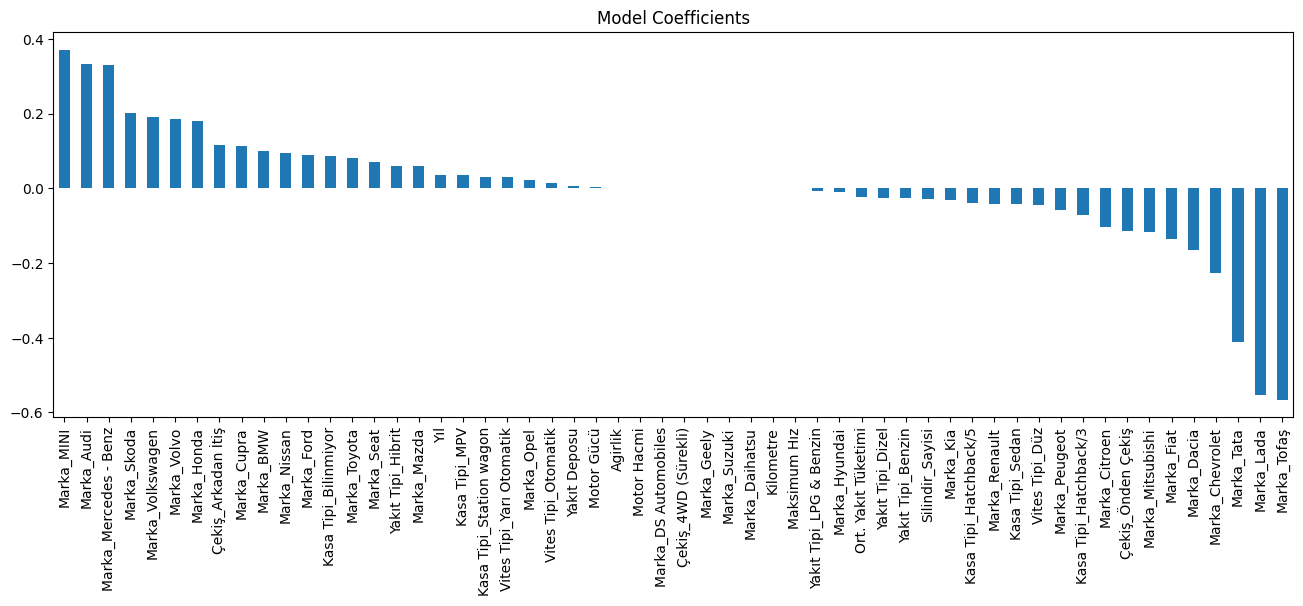

In [293]:
predictors = x_train.columns
coef = pd.Series(lreg_1_cv.coef_,predictors).sort_values(ascending=False)
plt.figure(figsize=[16,5])
coef.plot(kind='bar', title='Model Coefficients')

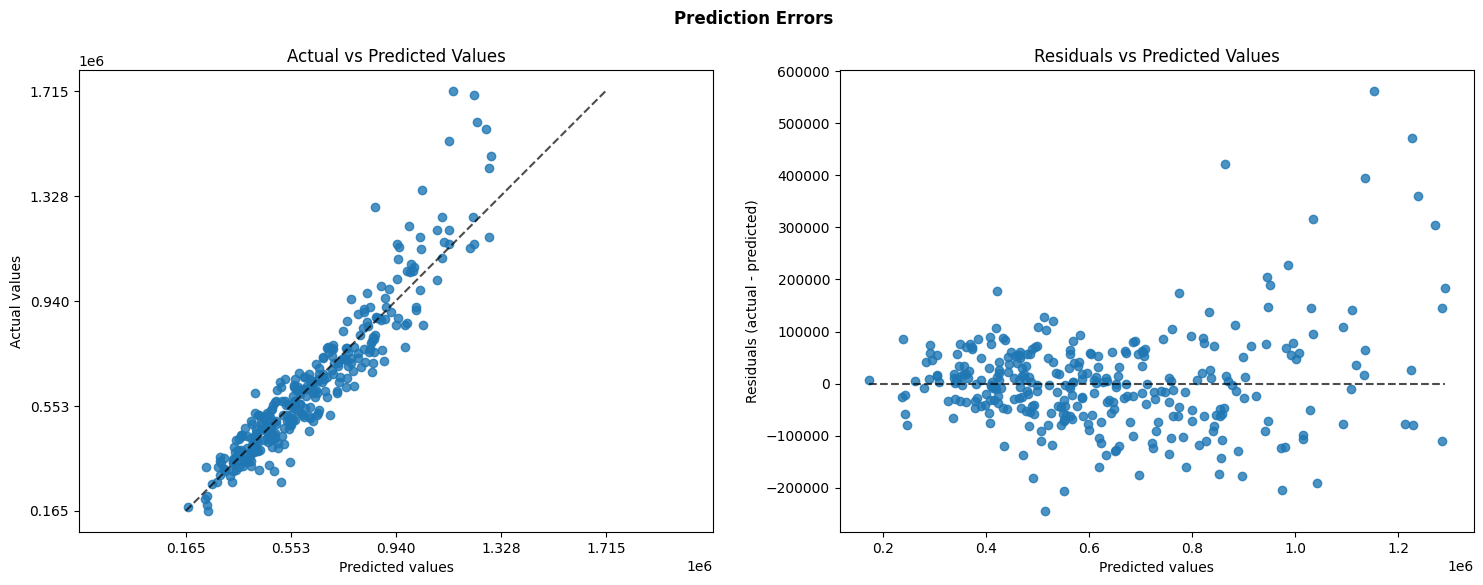

In [294]:
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(1, 2, figsize=[18,6])
fig.suptitle("Prediction Errors", weight="bold")

PredictionErrorDisplay.from_predictions(real_y_cv, real_pred, kind="actual_vs_predicted", ax=axs[0])
axs[0].set_title("Actual vs Predicted Values")

PredictionErrorDisplay.from_predictions(real_y_cv, real_pred, kind="residual_vs_predicted", ax=axs[1])
axs[1].set_title("Residuals vs Predicted Values");

In [259]:
# Ana model

In [310]:
lreg_3 = LinearRegression()

lreg_3.fit(x_train,y_train)

pred = lreg_3.predict(x_test)

# R2 Skor
print("R2 Score:", r2_score(y_test, pred))

R2 Score: 0.8939751398181097


In [311]:
from sklearn.metrics import mean_squared_error
pred = lreg_3.predict(x_test)

# MSE değerini hesapla
mse = mean_squared_error(y_test, pred)

# MSE değerini yazdır
print("MSE Değeri (lreg_3):", mse)


MSE Değeri (lreg_3): 0.018319149784273302


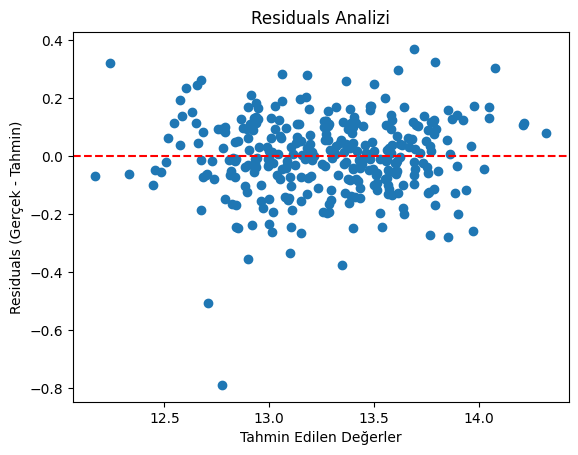

In [312]:
residuals = y_test - pred
plt.scatter(pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Tahmin Edilen Değerler")
plt.ylabel("Residuals (Gerçek - Tahmin)")
plt.title("Residuals Analizi")
plt.show()

In [313]:
X = df.drop(["Fiyat"],axis=1)
X = pd.get_dummies(X , columns=["Marka","Vites Tipi", "Yakıt Tipi", "Kasa Tipi", "Çekiş"])
y = df["Fiyat"]

In [314]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

In [315]:
lreg_3 = LinearRegression()

lreg_3.fit(x_train,y_train)

pred = lreg_3.predict(x_test)

# R2 Skor
print("R2 Score:", r2_score(y_test, pred))

R2 Score: 0.8512802389989536


In [316]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score
cv_scores = cross_val_score(lreg_3, x_train, y_train, cv=10, scoring=make_scorer(r2_score))

print("Çapraz Doğrulama Skorları:")
print(cv_scores)

print(f"Ortalama R2 Skoru: {cv_scores.mean():.4f}")

Çapraz Doğrulama Skorları:
[0.84815816 0.83920208 0.83248994 0.76014632 0.8309349  0.79319632
 0.80669033 0.85398204 0.738929   0.84659646]
Ortalama R2 Skoru: 0.8150


In [317]:
import tkinter as tk
from tkinter import ttk

In [268]:
class LinearRegressionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Linear Regression Model App")
        self.root.geometry("800x600")

        
        style = ttk.Style()
        style.configure("Main.TFrame", background="#37474f")  # Ana frame arkaplan rengi
        style.configure("TFrame", background="#f0f0f0")       # Giriş frame arkaplan rengi
        style.configure("TLabel", background="#f0f0f0", font=("Arial", 12), padding=5, foreground="#212121")  # Etiketler
        style.configure("TEntry", padding=5)                  # Giriş kutuları
        style.configure("TButton", background="#4caf50", foreground="white", font=("Arial", 12), padding=10)  # Düğme
        style.configure("TLabel", background="#f0f0f0", font=("Arial", 14, "bold"), padding=10, foreground="#e91e63")  # Tahmin sonucu etiketi

        
        main_frame = ttk.Frame(self.root, style="Main.TFrame")
        main_frame.pack(fill=tk.BOTH, expand=True)

        
        self.canvas = tk.Canvas(main_frame, bg="#f0f0f0")
        self.scrollbar = ttk.Scrollbar(main_frame, orient="vertical", command=self.canvas.yview)
        self.scrollable_frame = ttk.Frame(self.canvas, style="TFrame")

        
        self.input_entries = {}
        for row, column in enumerate(x_train.columns):
            ttk.Label(self.scrollable_frame, text=column + ":", style="TLabel").grid(row=row, column=0, padx=10, pady=5, sticky="e")
            self.input_entries[column] = ttk.Entry(self.scrollable_frame, style="TEntry")
            self.input_entries[column].grid(row=row, column=1, padx=10, pady=5, sticky="w")

       
        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all"))
        )

        
        self.canvas.create_window((0, 0), window=self.scrollable_frame, anchor="nw")
        self.canvas.configure(yscrollcommand=self.scrollbar.set)

        
        self.canvas.pack(side="left", fill="both", expand=True)
        self.scrollbar.pack(side="right", fill="y")

        
        ttk.Button(main_frame, text="Tahmin Yap", command=self.predict, style="TButton").pack(pady=10)

        
        self.result_label = ttk.Label(main_frame, text="", style="TLabel")
        self.result_label.pack(pady=10)

        
        self.model = LinearRegression()
        self.model.fit(x_train, y_train)

    def predict(self):
        
        user_input = {}
        for column, entry in self.input_entries.items():
            try:
                user_input[column] = float(entry.get())
            except ValueError:
                self.result_label.config(text="Hatalı giriş. Sayı giriniz.")
                return

 
        user_input_df = pd.DataFrame([user_input])

        
        prediction = self.model.predict(user_input_df)

        

        
        self.result_label.config(text=f"Tahmin: {prediction[0]:.2f}")


In [269]:
root = tk.Tk()
app = LinearRegressionApp(root)
root.mainloop()